# Imports

In [496]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load Data

In [513]:
# Risk Free Rate
rf_rate = pd.read_csv('data/rf_data.csv', index_col=0, parse_dates=True)

In [498]:
# Models
log_reg_results = pd.read_pickle('models/log_reg_results.pkl')
rf_results = pd.read_pickle('models/rf_results.pkl')
svm_results = pd.read_pickle('models/svm_results.pkl')
xgb_results = pd.read_pickle('models/xgb_results.pkl')

In [499]:
# S&P 500 data
sp500_data = pd.read_csv('data/s&p500_data.csv', index_col = 0, parse_dates=True)
sp500_data['Daily Returns'] = sp500_data['Close'].pct_change()

In [500]:
indicators = pd.read_csv('data/indicators.csv', index_col=0, parse_dates=True).loc['1997-01-01':]
indicators_w_polyterns = pd.read_csv('data/indicators_w_polyterms.csv', index_col=0, parse_dates=True).loc['1997-01-01':]
Y_Matrix = pd.read_csv('data/Y_Matrix.csv', index_col=0, parse_dates=True)

# Apply Models

In [501]:
def fit_models(indicators, params):
    final = []
    for type, tenure in tqdm(params.items()):
        per_strategy = []
        for i in range(len(tenure)):
            model = tenure[i]
            current_year = str(2000 + i)
            current_indicators = indicators.loc[current_year]
            probabilities = model.predict_proba(current_indicators)
            per_strategy.append(
                pd.DataFrame(probabilities[: , 1], index=current_indicators.index, columns=[f'{type}'])
            )
        final.append(pd.concat(per_strategy, axis=0))

    return pd.concat(final, axis=1)

In [503]:
prob_log_reg = fit_models(indicators_w_polyterns, log_reg_results)
prob_rf = fit_models(indicators, rf_results)
prob_xgb = fit_models(indicators, xgb_results)
prob_svm = fit_models(indicators, svm_results)


100%|██████████| 8/8 [00:00<00:00, 15.69it/s]


# Rescale Position from Probabilities

In [542]:
def compute_position(probabilities):
    position = probabilities.applymap(
        lambda x: min(1, (1/(1+np.exp(-20*(x-0.75))) - 1/(1+np.exp(5))) /
                         (1/(1+np.exp(-5)) - 1/(1+np.exp(5))) * 1000) if x >= 0.5 else 0
    )
    return position.shift(1).dropna()

In [543]:
position_log_reg = compute_position(prob_log_reg)
position_rf = compute_position(prob_rf)
position_xgb = compute_position(prob_xgb)
position_svm = compute_position(prob_svm)

In [544]:
(position_log_reg > 0.1).mean()

long 3 days      0.363130
short 3 days     0.314617
long 5 days      0.358199
short 5 days     0.341021
long 8 days      0.389534
short 8 days     0.305710
long 10 days     0.478289
short 10 days    0.273739
dtype: float64

# Backtest Strategy

In [545]:
def backtest_strategy(position, asset, rf_data, tc=0.0005):

    total_returns = pd.DataFrame(index=position.index)

    for n in (3, 5, 8, 10):
        # Resample and forward-fill positions
        current_position = position.filter(like=f'{n} days').resample(f'{n}B').first().reindex(asset.index).ffill().dropna()

        # Choose the larger position (comparing long vs. absolute value of short)
        current_position[f'pos {n} days'] = np.where(
            current_position[f'long {n} days'] > abs(current_position[f'short {n} days']),
            current_position[f'long {n} days'],
            current_position[f'short {n} days']
        )

        # Define risk-free position based on the absolute position taken
        current_position['risk free pos'] = 1 - np.abs(current_position[f'pos {n} days'])

        current_position['change in pos'] = np.abs(current_position[f'pos {n} days'].diff().fillna(0))

        # Calculate returns, aligning the indices properly.
        # Reindex asset returns and rf_rate to the index of current_position.
        aligned_asset_returns = asset['Daily Returns'].reindex(current_position.index)
        aligned_rf_data = rf_data['Close'].reindex(current_position.index)

        returns = current_position[f'pos {n} days'] * aligned_asset_returns.values + current_position['risk free pos'] * (aligned_rf_data.values/365/100) - tc * current_position['change in pos']

        # Store returns in a DataFrame with an appropriate column name
        returns_df = pd.DataFrame(returns, index=current_position.index, columns=[f'returns {n} days'])
        # Merge with total_returns on the index
        total_returns = pd.merge(total_returns, returns_df, left_index=True, right_index=True, how='outer')

    return total_returns

In [546]:
returns_log_reg = backtest_strategy(position_log_reg, sp500_data, rf_rate)
returns_rf = backtest_strategy(position_rf, sp500_data, rf_rate)
returns_xgb = backtest_strategy(position_xgb, sp500_data, rf_rate)
returns_svm = backtest_strategy(position_svm, sp500_data, rf_rate)

In [547]:
cum_returns_log_reg = (1 + returns_log_reg).cumprod(axis = 0) - 1
cum_returns_rf = (1 + returns_rf).cumprod(axis = 0) - 1
cum_returns_xgb = (1 + returns_xgb).cumprod(axis = 0) - 1
cum_returns_svm = ( 1 + returns_svm).cumprod(axis = 0) - 1

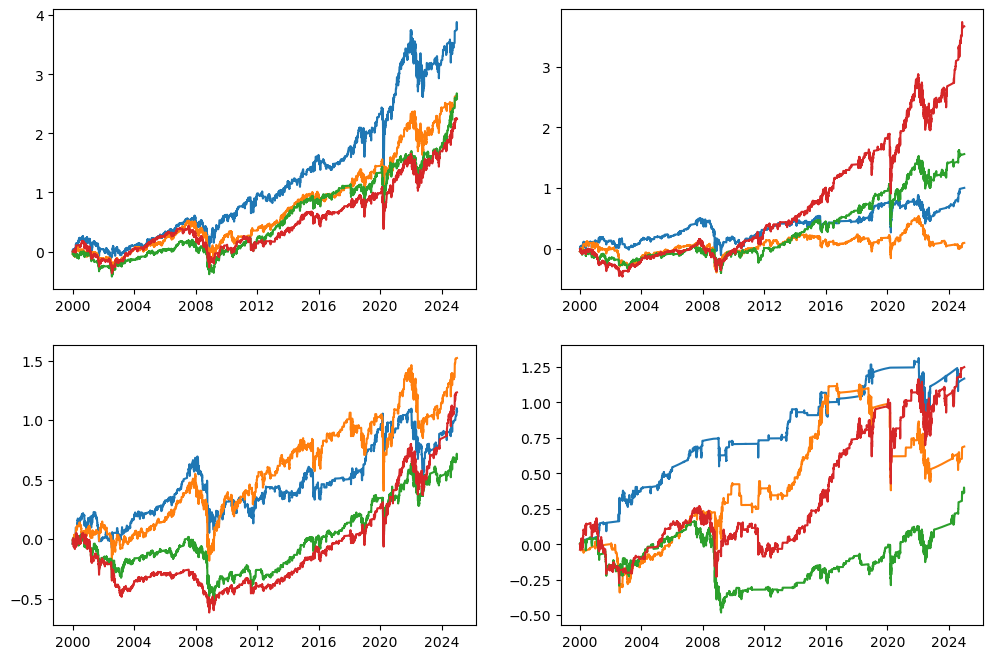

In [548]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8))
ax[0, 0].plot(cum_returns_log_reg)
ax[0, 1].plot(cum_returns_rf)
ax[1, 0].plot(cum_returns_xgb)
ax[1, 1].plot(cum_returns_svm)

In [549]:
2.5**(1/25)

1.037331581929148